# COMP47670 Assignment 2 - Student 20200891 - Connie Purcell

## Installing and importing required packages

In [1]:
! python -m pip install nltk
! python -m pip install sklearn
! python -m pip install matplotlib
! python -m pip install mlxtend

In [2]:
import os
import urllib.request
import csv
import pandas as pd
import json
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
from bs4 import BeautifulSoup
from collections import Counter
import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_files
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

## <font color=red>Task 1: Data Collection</font> 

### First I will use requests package to get the website information

In [3]:
#Using requests function to get website html data
ucdnews = requests.get("http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-001.html") 


### Checking the response to see if I was successful in requesting the website information, response status "200". If unsuccessful I would get error 404 status

In [4]:
ucdnews #Output is response 200 so successfully requested website

<Response [200]>

### Creating a for loop to run through the url link and edit it in order to get all the article data saved to a list. Then saving the information I need to a dictionary and appending my list with this selected information.

In [5]:
months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"] #Making list of months
article_list = []  #Making empty list for the article data

for month in months:  #Creating for loop to loop through and edit url in order to grab article for each month page
    number = "000"
    status = 200     #Status 200 means website url exists and successful, so if not 200 means we can stop looping numbers and cheange month.
    while status == 200:
        number = str(int(number)+1).zfill(3) #Change "000" string to an integer and add 1, then add 0s so it is 3 digits and then convert back to string
        url = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-" + month + "-" + number + ".html"  #url is the url from website, plus month list, -, number variable and .html
        url_ucd_req = requests.get(url) #request the url data
        status = url_ucd_req.status_code #check the status of url, so loop continues and stops when reaches 404 status and then loops to next month etc.

    
        ucd_news_content = url_ucd_req.content #variable to save the requested url response content 
        ucd_soup = BeautifulSoup(ucd_news_content, 'html.parser') #Using the Beautiful Soup package to pull the response content data from the url to the variable ucd_soup and parse it
        mydivs = ucd_soup.find_all("div", {"class": "article"}) #Searching ucd_soup to find all div tag content with the class "article"

        for article_block in mydivs: #Running another For loop to get only the website article data needed, the title, date, category and snippet.
            title = article_block.find('a').text.encode("ascii", "ignore").decode().replace("  "," ") #Find and grab the a tag article text data and remove unicode from this data, remove double spaces and replace with one space. Cleaning data.
            mydates = article_block.find_all('p',{"class":"metadata"})[0].text #Find and grab the dates text data. P tag, metadata class also has category info, so only select first element of p metadata
            mycategory = article_block.find_all('p',{"class":"metadata"})[1].text.replace("Category: ","") #Find and grab the category text data. P tag, metadata class also has dates info, so only select second element of p metadata in article chunk. Also remove "Category:" from text
            snip = article_block.find('p',{"class":"snippet"}).text.encode("ascii", "ignore").decode().replace("  "," ") #Find and grab the p tag snippet text data and remove unicode from this data, remove double spaces and replace with one space. Cleaning data.


            #Create article dictionary assigning variables created in previous loop 
            article_dict = {
              "title": title,
              "date": mydates,
              "category": mycategory,
               "snippet": snip, 
            } 

            article_list.append(article_dict)  #Append article list with dictionary info to organise data
            

### Now that we have article data saved to a list, we now need to filter this data to only grab articles with 3 different categories: UK News, Books and Music Categories

In [6]:
categories = ["UK-News", "Books", "Music"] #Creating list with the categories we want; Books, Music and UK News
articles = article_list #Saving our article_list data from previous step to a variable articles
article_approved = [] #Empty list to save our new filtered articles

for article in articles:
    category_get = article["category"]  #Check category in articles
    if category_get in categories:   #If the category in article we checked is in the list categories above...
        article_approved.append(article) #Append our empty list article_approved with the article checked. If not nothing happens
        

### Convert our list of filtered articles into a JSON File

In [7]:
temp = json.dumps(article_approved, indent=1) #Convert our list containing filtered article data into a JSON strings

In [8]:
jsonFile = open("article.json", "w")
jsonFile.write(temp)
jsonFile.close()
#Saving our JSON strings from JSON dumps into a JSON file, so we can view the data and see if it is filtered and formatted correctly

##  <font color=red>Task 2: Binary Text Classification</font> 

### Load the data from Task 1 and create a set of documents, one per news story. Each document should consist of the concatenation of the story’s title and text snippet. Each document should also have a class label, based on the story’s news category.

#### For this I have created a data frame, each row is a "seperate document" with the story title and snippet and category label

In [9]:
dataframe = pd.DataFrame(article_approved) 
#Converting list to a pandas dataframe as I am happy with the JSON output of the approved articles list

dataframe = dataframe.drop(columns='date') #Drop "date" column as not needed for classification tasks

### Now that we have a dataframe I need to filter it to only have two categories for Binary Text Classification. I also need to amend the dataframe to have a numeric representative of the two types of category.

In [10]:
dataframe = dataframe.sort_values('category') #Sort dataframe by category

dataframe['cat_id'] = (dataframe.groupby(['category']).cumcount()==0).astype(int) #Create new column of cat_id with integer count of categories

dataframe['cat_id'] = dataframe['cat_id'].cumsum() #Cumulative sum of categories as value in cat_id column. Numeric representation categories


In [11]:
dataframe_bi = dataframe.loc[dataframe['cat_id'] < 3] #Create new data frame with only 2 categories, categories with id less than 3

In [12]:
 display(dataframe_bi) #Viewing dataframe see if everything tranferred correctly

,title,category,snippet,cat_id
2354,Clothes and Other Things that Matter by Alexan...,Books,Summary: Alexandra Shulmans introduction to he...,1
2259,Orwell prize for fiction shortlist replays 201...,Books,"The clash between Bernardine Evaristos Girl, W...",1
3970,Missing voices: guide to female philosophers c...,Books,Summary: Two philosophy graduates are bringing...,1
3971,Bluebird by Malcolm Knox review vivid characte...,Books,Just a short drive from the sprawling suburbs ...,1
1334,Poetry book of the month: Loss by David Harsen...,Books,"This is a long watch of a poem, a tormented vi...",1
...,...,...,...,...
2352,"The 100 greatest UK No 1s: No 6, Michael Jacks...",Music,Billie Jean is not cancelled. Whatever persona...,2
2353,Whit Dickey Trio: Expanding Light review pin-s...,Music,Summary: A post-Coltrane coterie of American f...,2
811,James Blunt review beige balladeer turns up th...,Music,Summary: Having a global smash as couple-frien...,2
2330,Add some township jive! How London's jazz scen...,Music,"Although its live scene is currently on pause,...",2


In [13]:
dataframe_bi.isnull().sum() #Checking there is no null values in dataframe

title       0
category    0
snippet     0
cat_id      0
dtype: int64

### Creating data with the text data from title and snippet for classification and prediction, and target data of the categories aiming to predict. 

### Converting to list format for analysis purposes by classifiers

In [14]:
bi_data = (dataframe_bi["title"] + " " + dataframe_bi["snippet"] ).tolist()
bi_target = dataframe_bi["category"].tolist() 

#Creating bi_data with title and snippet text to list. bi_target is variable of categories for prediction converted to list.

## First we will test the accuracy of a number of classifiers to determine which classifier we will use on our data for binary classification

### We are going to be testing six different classifiers cross validation accuracy score to test which has the highest accuracy score to use as our final classifier for prediction. The six classifiers are:

### 1. Stochastic Gradient Descent or "SGD" Classifier.

### 2. k Nearest Neighbour or "KN-n" Classifier

### 3. Decision Tree Classifier

### 4. Naive Bayes Classifier

### 5. Logistic Regression

### 6. Gradient Boosting Classifier






### We will use the pipeline function to transform the data for classification. Pipeline gives you a single interface for all 3 steps of transformation and resulting estimator. It encapsulates transformers and predictors inside.






###  SGD Classifier.  

In [15]:
seed = 123 #set seed number
np.random.seed(seed) #set seed so numbers reported remain the same so my report makes sense!

pipeline1 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('clf', SGDClassifier())
]) 
#Using pipeline function from sklearn to vectorise data using count vectoriser, removing common phrases in english language and apply SGD classifier

SGDC1 = cross_val_score(pipeline1, bi_data, bi_target,
cv=10, scoring="accuracy").mean()

#Evaluate SGD classifier by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

#Using pipeline function again to vectorise data using count vectoriser and TFIDF transformer and apply SGD classifier
pipelineA = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier())
])

SGDC2 = cross_val_score(pipelineA, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate SGD classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

In [16]:
#Print out the mean of accuracy scores calculated in last code chunk
print("SGD Classifier Accuracy Score with Count Vectoriser", SGDC1)
print("SGD Classifier Accuracy Score with TFIDF Transformer", SGDC2)

SGD Classifier Accuracy Score with Count Vectoriser 0.9040923769149538
SGD Classifier Accuracy Score with TFIDF Transformer 0.9192956948929464


### KNn Classifier

In [17]:
np.random.seed(seed) #set seed so numbers reported remain same

pipeline2 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('clf', KNeighborsClassifier(n_neighbors=3))
]) #Using pipeline function from sklearn to vectorise data, removing common phrases in english language and apply k-Nearest Neighbour Classifier


KNn1 = cross_val_score(pipeline2, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate KNN classifier by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

#Using pipeline function again to vectorise data using count vectoriser and TFIDF transformer and apply KNN classifier
pipelineB = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

KNn2 = cross_val_score(pipelineB, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate KNN classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

In [18]:
#Print out the mean of accuracy scores calculated in last code chunk
print("KNN Classifier Accuracy Score with Count Vectoriser", KNn1)
print("KNN Classifier Accuracy Score with TFIDF Transformer", KNn2)

KNN Classifier Accuracy Score with Count Vectoriser 0.6898784836473271
KNN Classifier Accuracy Score with TFIDF Transformer 0.8217275523790576


### Decision Tree Classifier

In [21]:
np.random.seed(seed) #set seed so numbers reported remain same

pipeline3 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('clf', DecisionTreeClassifier())
]) 
#Using pipeline function from sklearn to vectorise data, removing common phrases in english language and apply Decision Tree Classifier

Tree1 = cross_val_score(pipeline3, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate Decision Tree classifier by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


pipelineC = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', DecisionTreeClassifier())
])
#Using pipeline function again to vectorise data using count vectoriser and TFIDF transformer and apply Decision Tree classifier

Tree2 = cross_val_score(pipelineC, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate Decision Tree classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

In [22]:
#Print out the mean of accuracy scores calculated in last code chunk
print("Decision Tree Classifier Accuracy Score with Count Vectoriser", Tree1)
print("Decision Tree Classifier Accuracy Score with TFIDF Transformer", Tree2)

Decision Tree Classifier Accuracy Score with Count Vectoriser 0.8579329976584381
Decision Tree Classifier Accuracy Score with TFIDF Transformer 0.8512970416736811


###  Naive Bayes Classifier

In [23]:
np.random.seed(seed) #set seed so numbers reported remain same

pipeline4 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('clf', MultinomialNB())
])
#Using pipeline function from sklearn to vectorise data, removing common phrases in english language and apply Naive Bayes Classifier

Bayes1 = cross_val_score(pipeline4, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate Naive Bayes classifier by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


pipelineD = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultinomialNB())
])

#Using pipeline function again to vectorise data using count vectoriser and TFIDF transformer and apply Naive Bayes classifier

Bayes2 = cross_val_score(pipelineD, bi_data, bi_target,
cv=10, scoring="accuracy").mean()

#Evaluate Naive Bayes classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


In [24]:
#Print out the mean of accuracy scores calculated in last code chunk
print("Naive Bayes Classifier Accuracy Score with Count Vectoriser", Bayes1)
print("Naive Bayes Classifier Accuracy Score with TFIDF Transformer", Bayes2)

Naive Bayes Classifier Accuracy Score with Count Vectoriser 0.9339411701688067
Naive Bayes Classifier Accuracy Score with TFIDF Transformer 0.930901730919331


###  Logistic Regression

In [25]:
np.random.seed(seed) #set seed so numbers reported remain same

pipeline5 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('clf', linear_model.LogisticRegression())
])
#Using pipeline function from sklearn to vectorise data, removing common phrases in english language and use logistic regression

LogReg1 = cross_val_score(pipeline5, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate using Logistic Regression by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


pipelineE = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', linear_model.LogisticRegression())
])
#Using pipeline function again to vectorise data using count vectoriser and TFIDF transformer and apply Logistic Regression

LogReg2 = cross_val_score(pipelineE, bi_data, bi_target,
cv=10, scoring="accuracy").mean()

#Evaluate Logistic Regression classification including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

In [26]:
#Print out the mean of accuracy scores calculated in last code chunk
print("Logistic Regression Accuracy Score with Count Vectoriser", LogReg1)
print("Logistic Regression Accuracy Score with TFIDF Transformer", LogReg2)

Logistic Regression Accuracy Score with Count Vectoriser 0.9198481810807916
Logistic Regression Accuracy Score with TFIDF Transformer 0.9289733857761588


### Gradient Boosting Classifier. 

In [27]:
np.random.seed(seed) #set seed so numbers reported remain same

pipeline6 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('clf', GradientBoostingClassifier())
])
#Using pipeline function from sklearn to vectorise data, removing common phrases in english language and use gradient boosting classifier

GBoost_1 = cross_val_score(pipeline6, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate using gradient booster by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

pipelineF = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', GradientBoostingClassifier())
     ])
#Using pipeline function again to vectorise data using count vectoriser and TFIDF transformer and apply Gradient Boosting

GBoost_2 = cross_val_score(pipelineF, bi_data, bi_target,
cv=10, scoring="accuracy").mean()
#Evaluate Gradient Boosting classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


In [28]:
#Print out the mean of accuracy scores calculated in last code chunk
print("Gradient Boosting Accuracy Score with Count Vectoriser", GBoost_1)
print("Gradient Boosting Accuracy Score with TFIDF Transformer", GBoost_2)

Gradient Boosting Accuracy Score with Count Vectoriser 0.8571012075113634
Gradient Boosting Accuracy Score with TFIDF Transformer 0.8557123398784837


In [29]:
#Created a dataframe to easily compare the accuracy score values across classifiers to see which has the best accuracy score

BinaryClassScore = pd.DataFrame([[SGDC1, SGDC2, KNn1, KNn2, Tree1, Tree2,Bayes1, Bayes2, LogReg1, LogReg2, GBoost_1, GBoost_2]],
                                columns=['SGDC1','SGDC2','K Nearest Neighbour 1',"K Nearest Neighbour2","Descision Tree 1", "Decision Tree 2", "Naive Bayes 1", "Naive Bayes 2", "Logistic Regression 1",  "Logistic Regression 2", "Gradient Boosting 1", "Gradient Boosting 2"])

#Viewing Dataframe of results
BinaryClassScore

,SGDC1,SGDC2,K Nearest Neighbour 1,K Nearest Neighbour2,Descision Tree 1,Decision Tree 2,Naive Bayes 1,Naive Bayes 2,Logistic Regression 1,Logistic Regression 2,Gradient Boosting 1,Gradient Boosting 2
0,0.904092,0.919296,0.689878,0.821728,0.857933,0.851297,0.933941,0.930902,0.919848,0.928973,0.857101,0.855712


### According to the above scores the Naive Bayes model had the highest accuracy score without using the TFIDF Transformer, we will use this for our model classifier.

## Split the data into training and test data for final analysis by X classifier.

In [33]:
np.random.seed(seed) #set seed so numbers reported remain same

data_train, data_test, target_train, target_test = train_test_split(bi_data, bi_target) 
#Splitting the data into training and test data for classification and prediction models

## Use the training and test data for classification and prediction. Get accuracy score and classification report for evaluation.

In [34]:
np.random.seed(seed) #Set seed

vectorizer = CountVectorizer(stop_words="english", max_features=1000, decode_error="ignore")  #Save count vectorizer and its parameters to variable "vectorizer"
vectorizer.fit(data_train) #Apply vectorizer to training data, to tokenise or vectorise it
Data_train_vectorized = vectorizer.transform(data_train) #Transform the training data into vectorized form

cls = MultinomialNB() #Naive Bayes classifier saved to variable cls
cls.fit(vectorizer.transform(data_train), target_train) #Fit the classification model transformed training data to the target data

y_pred = cls.predict(vectorizer.transform(data_test)) #Use the classification model to predict the categories of the vectorised test data and save to variable


## Confusion Matrix, Classification Report and Accuracy Score for Evaluation of Model

Accuracy Score of Naive Bayes prediction 0.907182320441989
              precision    recall  f1-score   support

       Books       0.92      0.90      0.91       468
       Music       0.90      0.91      0.90       437

    accuracy                           0.91       905
   macro avg       0.91      0.91      0.91       905
weighted avg       0.91      0.91      0.91       905



C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['Books', 'Music'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


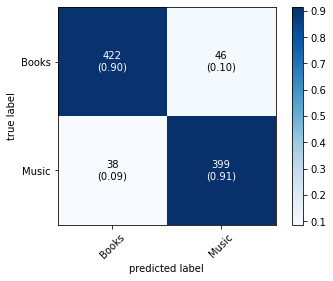

In [35]:
np.random.seed(seed) #Set seed

Accuracy_BiClass = (accuracy_score(target_test, y_pred)) #Calculate accuracy score for the predictions, data test predictions vs target test data
Bi_Classification_Report =(classification_report(target_test, y_pred)) #Use classification report function to create report on model results

print("Accuracy Score of Naive Bayes prediction", Accuracy_BiClass) #Print accuracy score of Bi Classification Task
print(Bi_Classification_Report) #Print classification report of Bi Classification Task


labels = ['Books', 'Music'] #Create labels for confusion matrix, from categories in dataset
cm = confusion_matrix(target_test, y_pred, labels) #Create confusion matrix with Bi Classification Task results
classes = ['Books', 'Music'] #Create classes for plotting

figure, ax = plot_confusion_matrix(conf_mat = cm, 
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)  #Use Matplot to plot confusion matrix showing values and colour based on accuracy

plt.show() #Show confusion matrix plot

## Evaluation Report and Discussion

### The accuracy score of our Naive Bayes model was 0.91, so 91% accuracy. Split between the two categories there was 0.01 of a difference between their scores so overall I would say our model was successful. 

### Similarly the confusion matrix illustrates the accuracy of the model as the False Positive and False Negative scores are low at 0.09-0.1. 

### Confusion Matrix Miscalculation Score is 0.093, further showing the models accuracy. (FP+FN/All values) So 9.28% Misclassification.

### Precision score and recall or sensitivity scores are 90% or 91% which shows the model is accurate most of the time. 

## <font color=red>Task 3: Multi-Class Text Classification</font> 

### We will be using the dataframe we created previously that has numeric representation of each category and its documents.

In [36]:
dataframe #Viewing dataframe from previous section

,title,category,snippet,cat_id
2354,Clothes and Other Things that Matter by Alexan...,Books,Summary: Alexandra Shulmans introduction to he...,1
2259,Orwell prize for fiction shortlist replays 201...,Books,"The clash between Bernardine Evaristos Girl, W...",1
3970,Missing voices: guide to female philosophers c...,Books,Summary: Two philosophy graduates are bringing...,1
3971,Bluebird by Malcolm Knox review vivid characte...,Books,Just a short drive from the sprawling suburbs ...,1
1334,Poetry book of the month: Loss by David Harsen...,Books,"This is a long watch of a poem, a tormented vi...",1
...,...,...,...,...
3831,Geoffrey Parker obituary,UK-News,"Summary: My father, Geoffrey Parker, who has d...",3
3825,UK commuters: share your experiences of travel...,UK-News,About 90% of train services were restored on M...,3
1507,Digested week: fear and loathing in coronaviru...,UK-News,Monday So here is how my typical day begins. I...,3
1459,Thousands of students stranded at university a...,UK-News,Thousands of students are stranded in universi...,3


In [37]:
dataframe.isnull().sum()  #Checking there is no null values in dataframe

title       0
category    0
snippet     0
cat_id      0
dtype: int64

### Creating data with the text data from title and snippet for classification and prediction, and target data of the categories aiming to predict. 

### Converting to list format for analysis purposes by classifiers

In [38]:
raw_data = (dataframe["title"] + " " + dataframe["snippet"] ).tolist()
raw_target = dataframe["category"].tolist()
#Creating raw_data with title and snippet text to list. raw_target is variable of categories for prediction converted to list.

### We are going to be testing six different classifiers cross validation accuracy score to test which has the highest accuracy score to use as our final classifier for prediction. The six classifiers are:

### 1. Stochastic Gradient Descent or "SGD" Classifier.

### 2. k Nearest Neighbour or "KN-n" Classifier

### 3. Decision Tree Classifier

### 4. Naive Bayes Classifier

### 5. Gradient Boosting Classifier

### 6. Random Forest Classifier

### We will use the pipelines created for the analysis of classifiers for binary classification, we will just update these pipelines to be cross validated when analysing the multi-class data sets. The only exception is Random Forest Classifier which we will have to create a new pipeline as it wasn't used in the last section.

###  SGD Classifier.  

In [39]:
np.random.seed(seed) #Set seed

SGDC_1 = cross_val_score(pipeline1, raw_data, raw_target,
cv=10, scoring="accuracy").mean()

#Evaluate SGD classifier by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores.

SGDC_2 = cross_val_score(pipelineA, raw_data, raw_target,
cv=10, scoring="accuracy").mean()

#Evaluate SGD classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


###  KN-N Classifier.  

In [40]:
np.random.seed(seed) #Set seed

KNN_1 = cross_val_score(pipeline2, raw_data, raw_target,
cv=10, scoring="accuracy").mean() 
#Evaluate KNn classifier by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores

KNN_2 = cross_val_score(pipelineB, raw_data, raw_target,
cv=10, scoring="accuracy").mean()
#Evaluate KNN classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


###  Decision Tree Classifier.  

In [41]:
np.random.seed(seed) #Set seed

Tree_1 = cross_val_score(pipeline3, raw_data, raw_target,
cv=10, scoring="accuracy").mean()
#Evaluate Decision Tree classifier by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores.

Tree_2 = acc_scoresC = cross_val_score(pipelineC, raw_data, raw_target,
cv=10, scoring="accuracy").mean()
#Evaluate Decision Tree classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


###  Naive Bayes Classifier.  

In [42]:
np.random.seed(seed) #Set seed

Bayes_1 = cross_val_score(pipeline4, raw_data, raw_target,
cv=10, scoring="accuracy").mean()
#Evaluate Naive Bayes classifier by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores.

Bayes_2 = acc_scoresD = cross_val_score(pipelineD, raw_data, raw_target,
cv=10, scoring="accuracy").mean()
#Evaluate Naive Bayes classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.


###  Gradient Boosting Classifier.  

In [43]:
np.random.seed(seed) #Set seed

GBoost_1 = cross_val_score(pipeline6, raw_data, raw_target,
cv=10, scoring="accuracy").mean()

GBoost_2 = cross_val_score(pipelineF, raw_data, raw_target,
cv=10, scoring="accuracy").mean()

#Evaluate Gradient Booster including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.



###  Random Forest Classifier.  

In [44]:
np.random.seed(seed) #Set seed

pipeline7 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('clf', RandomForestClassifier())
])

Forest_1 = cross_val_score(pipeline7, raw_data, raw_target,
cv=10, scoring="accuracy").mean()

#Evaluate Random Forest classifier by cross validation Apply to full data and target labels for 10 folds, calculate accuracy scores.

pipelineG = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', RandomForestClassifier())
])

Forest_2 = cross_val_score(pipelineG, raw_data, raw_target,
cv=10, scoring="accuracy").mean()

#Evaluate Random Forest Classifier including TFIDF transformer process by cross validation. Apply to full data and target labels for 10 folds, calculate accuracy scores mean.

In [45]:
#Created a dataframe to easily compare the accuracy score values across classifiers to see which has the best accuracy score

MultiClassScore = pd.DataFrame([[SGDC_1,SGDC_2,KNN_1,KNN_2,Tree_1,Tree_2,Bayes_1, Bayes_2, GBoost_1, GBoost_2, Forest_1, Forest_2]],
                               columns=['SGDC1','SGDC2','K Nearest Neighbour 1',"K Nearest Neighbour2","Descision Tree 1", "Decision Tree 2", "Naive Bayes 1", "Naive Bayes 2", "Gradient Boosting 1", "Gradient Boosting 2", "Random Forest 1",  "Random Forest 2"])

MultiClassScore #View dataframe of scores

,SGDC1,SGDC2,K Nearest Neighbour 1,K Nearest Neighbour2,Descision Tree 1,Decision Tree 2,Naive Bayes 1,Naive Bayes 2,Gradient Boosting 1,Gradient Boosting 2,Random Forest 1,Random Forest 2
0,0.893587,0.907813,0.606676,0.796604,0.811195,0.793269,0.909289,0.902824,0.831321,0.827625,0.879179,0.876588


### According to the above scores the Naive Bayes model had the highest accuracy score once again without using the TFIDF Transformer, we will use this for our model classifier.

## Split the data into training and test data for final analysis by Naive Bayes classifier.

In [46]:
np.random.seed(seed) #Set seed

X_train, X_test, y_train, y_test = train_test_split(raw_data, raw_target)
#Splitting the data into training and test data for classification and prediction models

## Use the training and test data for classification and prediction. Get accuracy score and classification report for evaluation.

In [47]:
np.random.seed(seed) #Set seed

vectorizer.fit(X_train) #Apply vectorizer to training data, to tokenise or vectorise it
X1_train_vectorized = vectorizer.transform(X_train) #Transform the training data into vectorized form

cls = MultinomialNB() #Naive Bayes classifier saved to variable cls, just for clarity illustrating this again
cls.fit(vectorizer.transform(X_train), y_train) #Fit the classification model transformed training data to the target data

y1_pred = cls.predict(vectorizer.transform(X_test)) #Use the classification model to predict the categories of the vectorised test data and save to variable

## Confusion Matrix, Classification Report and Accuracy Score for Evaluation of Model

Accuracy Score of Naive Bayes prediction 0.8744460856720827
              precision    recall  f1-score   support

       Books       0.85      0.89      0.87       444
       Music       0.86      0.86      0.86       442
     UK-News       0.91      0.87      0.89       468

    accuracy                           0.87      1354
   macro avg       0.87      0.87      0.87      1354
weighted avg       0.88      0.87      0.87      1354



C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['Books', 'Music', 'UK-News'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


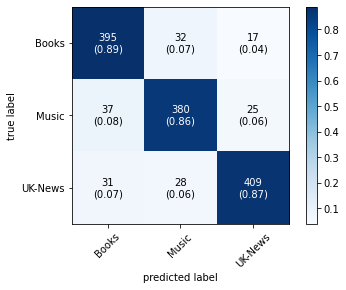

In [49]:
np.random.seed(seed) #Set seed

Accuracy_MultiClass = (accuracy_score(y_test, y1_pred)) #Calculate accuracy score for the predictions, data test predictions vs target test data
Multi_Classification_Report =(classification_report(y_test, y1_pred)) #Use classification report function to create report on model results

print("Accuracy Score of Naive Bayes prediction", Accuracy_MultiClass)  #Print accuracy score of Multi Classification Task
print(Multi_Classification_Report) #Print classification report of Multi Classification Task


labels=["Books", "Music", "UK-News"] #Create labels for confusion matrix, from categories in dataset
cm2 = confusion_matrix(y_test, y1_pred, labels) #Create confusion matrix with Bi Classification Task results
classes2 = ["Books", "Music", "UK-News"] #Create classes for plotting

figure, ax = plot_confusion_matrix(conf_mat = cm2,
                                   class_names = classes2,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True) #Use Matplot to plot confusion matrix showing values and colour based on accuracy

plt.show()  #Show confusion matrix plot


## Evaluation Report and Discussion

### The accuracy score of our Naive Bayes model was 0.87 or 87%. Naturally this accuracy score is lower than our bi-classification models accuracy score as adding more categories makes the classification and prediction tasks more difficult. However 87% accuracy is still a good score showing the model is mostly accurate. The model appears to be slightly more accurate with Book categorisation compared to Music and UK-News categories. 

### Similarly the confusion matrix illustrates the accuracy of the model. None of the False Positive and False Negative scores reach past 8%. 

### The accuracy score of our Naive Bayes model was 0.87 so 87% accuracy. Split between the two categories there was 0.01 of a difference between their scores so overall I would say our model was successful. 

### Similarly the confusion matrix illustrates the accuracy of the model as the False Positive and False Negative scores are low. lying between 4%-8%.

### Confusion Matrix Miscalculation Score is 0.1267 or 12.67%, further showing the models accuracy. (FP+FN/All values) A miscalculation score of 12.67% is still relatively low, naturally this is higher than our last classification task as there are more categories to predict.

### Precision score and recall or sensitivity scores are mostly around 87% which shows the model is accurate most of the time. 